In [7]:
import tensorflow as tf
import os
import cv2 
import imghdr
from matplotlib import pyplot as plt
import numpy as np 

C:\Users\Varrun\AppData\Local\Temp\ipykernel_12612\1072805634.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [38]:
# avoid OOM errors by setting GPU Memory comsumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
data_dir = 'Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
#remove any images not in the specifed type 
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            

In [11]:
#generates and reshapes dataset basedon images for proper use
data = tf.keras.utils.image_dataset_from_directory('Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/')
data_iterator = data.as_numpy_iterator()

Found 520 files belonging to 2 classes.


In [12]:
# Class 0 = Negative
# Class 1 = Postive 
batch = data_iterator.next()
batch[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

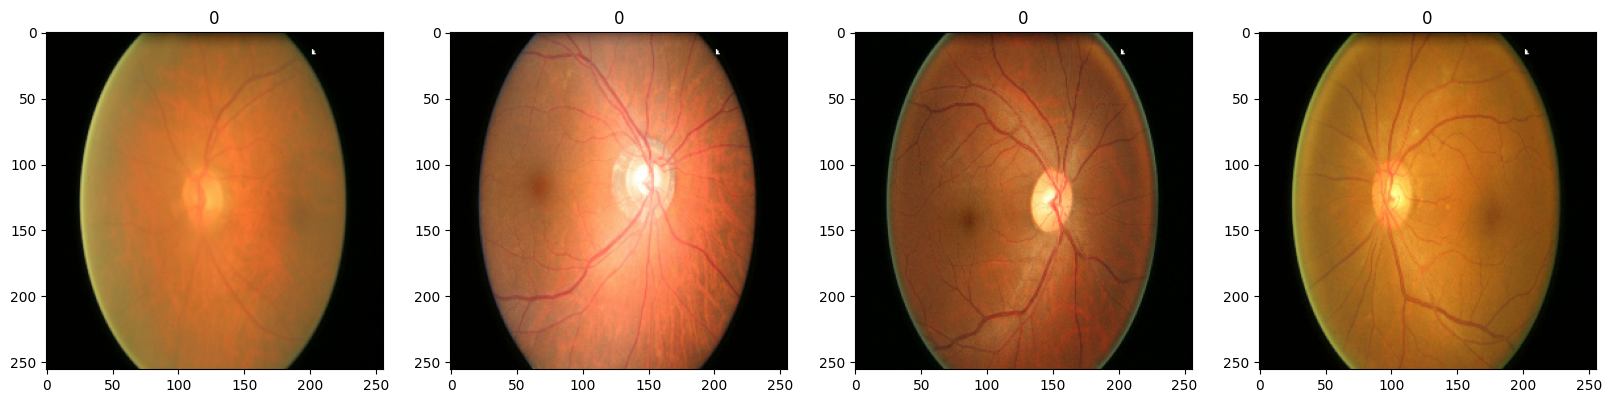

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].min()

0.0

In [15]:
len(data)

17

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 7s 517ms/step - loss: 0.7084 - accuracy: 0.6648 - val_loss: 0.5877 - val_accuracy: 0.7266
Epoch 2/20
11/11 [==============================] - 6s 521ms/step - loss: 0.5710 - accuracy: 0.7386 - val_loss: 0.5874 - val_accuracy: 0.7031
Epoch 3/20
11/11 [==============================] - 7s 543ms/step - loss: 0.5986 - accuracy: 0.7188 - val_loss: 0.6249 - val_accuracy: 0.7031
Epoch 4/20
11/11 [==============================] - 7s 553ms/step - loss: 0.5589 - accuracy: 0.7670 - val_loss: 0.5761 - val_accuracy: 0.7500
Epoch 5/20
11/11 [==============================] - 7s 550ms/step - loss: 0.5485 - accuracy: 0.7585 - val_loss: 0.5901 - val_accuracy: 0.7734
Epoch 6/20
11/11 [==============================] - 7s 549ms/step - loss: 0.5676 - accuracy: 0.7528 - val_loss: 0.6245 - val_accuracy: 0.7109
Epoch 7/20
11/11 [==============================] - 6s 513ms/step - loss: 0.5502 - accuracy: 0.7528 - val_loss: 0.5320 - val_accuracy: 0.7578
Epoch 

<function matplotlib.pyplot.show(close=None, block=None)>

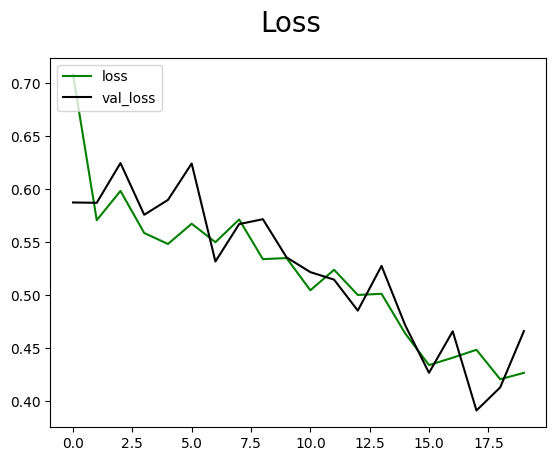

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='black', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

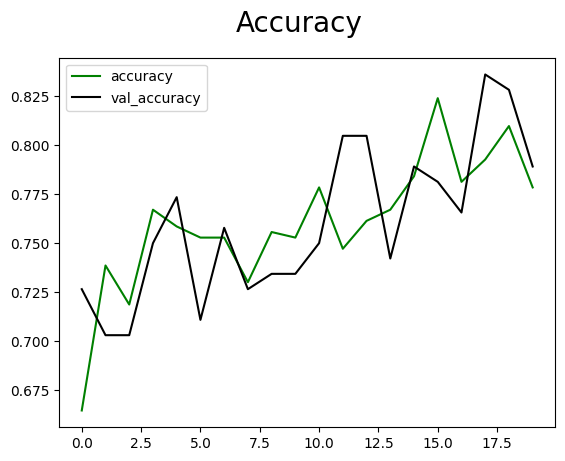

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='black', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show


In [28]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# Save model architecture to JSON file
model_json = model.to_json()
with open("Control_model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights("Control_model_weights.h5")


In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch 
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 [==============================] - 0s 37ms/step


In [37]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.5, Recall:0.48148149251937866, Accuracy:0.7749999761581421


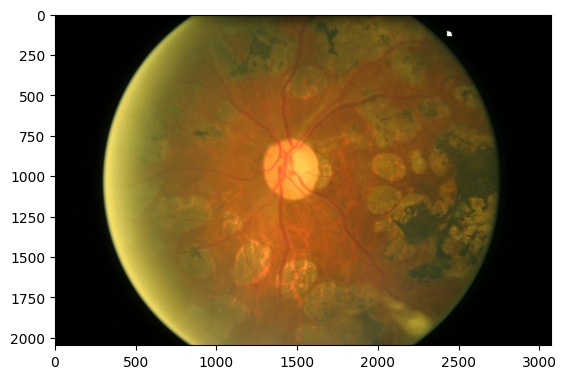

In [68]:
img = cv2.imread('Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/638.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

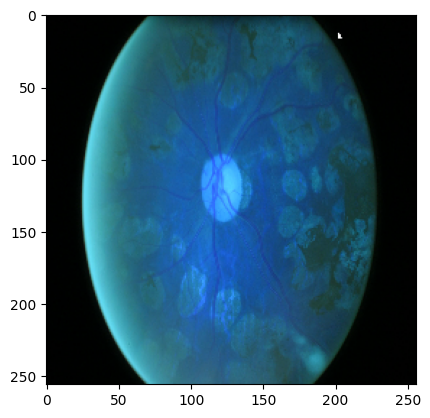

In [69]:
resize = tf.image.resize(img, (256,256))
bgr_img = resize.numpy().astype(int)
plt.imshow(bgr_img)
plt.show()

In [70]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [71]:
if yhat > 0.5: 
    print(f'Predicted class is Negative')
else:
    print(f'Predicted class is Positive')

Predicted class is Positive
